AgentCoder is a multi-agent framework designed to enhance code generation by leveraging three distinct roles to streamline the coding and validation process. This implementation is directly derived from the paper *"AgentCoder: Multi-Agent Code Generation with Effective Testing and Self-Optimization"*[@huang2024agentcodermultiagentbasedcodegeneration], with some minor modifications to the prompts to optimize its functionality within LangGraph.

### **Key Features of AgentCoder**
1. **Three Roles**: 
   - **Programmer**: Responsible for generating code based on requirements.
   - **Test Designer**: Generates comprehensive, independent test cases without being influenced by the program code. The test cases cover basic ones, edge cases, and large scale test cases, testing for performance.
   - **Test Executor**: A program (not an LLM persona) that runs the tests and provides feedback for further code refinement.
2. **Independent Test Creation**: Ensures objectivity and enhances the reliability of generated tests.
3. **Iterative Improvement**: Refines code through multiple iterations based on test feedback until all tests pass.

### **Notebook Objectives**
- Illustrate the implementation of the AgentCoder framework using LangGraph.
- Showcase the use of **Checkpointer (Memory)** in LangGraph to access the state of an executed graph.
- Direct derivation of the implementation from the research paper, with minor modifications to the prompts.

## Setup

In [2]:


from langgraph.graph import StateGraph, END, START, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    PromptTemplate,
)
from langchain_core.output_parsers.string import StrOutputParser
from pydantic import BaseModel, Field
from typing import List, Annotated, Literal
from typing_extensions import TypedDict
from operator import add, attrgetter
import textwrap
import os
from trustcall import create_extractor
from agentic.utils import *

## Prompts

We start with writing down the relevant prompts. They are copy-pasted from the appendix of the paper.

In [3]:


# first example from the HumanEval test dataset. Used as one-shot example.

human_eval_example = {
    "prompt": 'from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given threshold.\n    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n    False\n    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n    True\n    """\n',
    "entry_point": "has_close_elements",
}

In [4]:


# Programmer Prompt
coder_prompt = textwrap.dedent(
    """
    **Role**: You are a software programmer. 
    
    **Task**: As a programmer, you are required to complete the function. Use a Chain-of-Thought approach to break down the problem, create pseudocode, and then write the code in Python language. Ensure that your code is efficient, readable, and well-commented. For example: 
    
    **Input Prompt**: 
    ```python 
    {prompt}
    # TODO: Implement the logic to determine if any two numbers are closer than the threshold pass 

    # Add your code here to complete the function
    ```
    **Instructions**: 
    1. **Understand and Clarify**: Make sure you understand the task. 
    2. **Algorithm/Method Selection**: Decide on the most efficient way. 
    3. **Pseudocode Creation**: Write down the steps you will follow in pseudocode. 
    4. **Code Generation**: Translate your pseudocode into executable Python code.
    """
).strip()

# one-shot example
response = textwrap.dedent(
    '''
    As a software developer, I'll follow the Chain-of-Thought approach outlined in the prompt to complete the `has_close_elements` function. Let's break it down into the four steps: 
    
    1. **Understand and Clarify**: 
    - The task is to write a function that checks if any two numbers in a given list are closer to each other than a specified threshold. 
    - The function should return `True` if such a pair exists, otherwise `False`. 
    
    2. **Algorithm/Method Selection**: 
    - A straightforward way to solve this would be to compare each number with every other number in the list. 
    - We can use a nested loop where each number is compared to every number that comes after it in the list. 
    - The absolute difference between each pair will be calculated and compared to the threshold. 
    
    3. **Pseudocode Creation**: 
    ```
    function has_close_elements(numbers, threshold): 
        loop through each number in the list (i) 
            for each number, loop through the remaining numbers in the list (j) 
                if the absolute difference between numbers[i] and numbers[j] is less than or equal to the threshold 
                    return True 
    if no such pair is found, return False 
    ``` 
    
    4. **Code Generation**: 
    - Translate the pseudocode into Python code. Only implement the function. DO NOT add any test cases or explanations. 
    Return the python implementation of the function within triple quotes. Here's a complete example: 
    ```python 
    from typing import List 
    
    def has_close_elements(numbers: List[float], threshold: float) -> bool: 
        """ 
        Check if in given list of numbers, are any two numbers closer to each other than given threshold. 
        
        >>> has_close_elements([1.0, 2.0, 3.0], 0.5) 
        False 
        >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3) 
        True 
        """ 
        # Loop through each number in the list 
        for i in range(len(numbers)): 
            # For each number, loop through the remaining numbers 
            for j in range(i + 1, len(numbers)): 
                # If the absolute difference is less than or equal to the threshold, return True 
                if abs(numbers[i] - numbers[j]) <= threshold: 
                    return True 
                    
        # If no such pair is found, return False 
        return False 
        ```
'''
).strip()

In [5]:


# Test Designer Prompt
tester_prompt = textwrap.dedent(
    """
    **Role**: As a tester, your task is to create comprehensive test cases for the incomplete `{entry_point}` function. These test cases should encompass Basic, Edge, and Large Scale scenarios to ensure the code's robustness, reliability, and scalability. 
    
    **Input Code Snippet**: 
    ```python
    {prompt} 
    ```
    **1. Basic Test Cases**: 
    - **Objective**: To verify the fundamental functionality of the `{entry_point}` function under normal conditions. 
    
    **2. Edge Test Cases**: 
    - **Objective**: To evaluate the function's behavior under extreme or unusual conditions. 
    
    **3. Large Scale Test Cases**: 
    - **Objective**: To assess the function’s performance and scalability with large data samples. 
    
    **Instructions**: 
    - Implement a comprehensive set of test cases following the guidelines above. 
    - Ensure each test case is well-documented with comments explaining the scenario it covers. 
    - Pay special attention to edge cases as they often reveal hidden bugs. 
    - For large-scale tests, focus on the function's efficiency and performance under heavy loads.
    """
).strip()

# one-shot example
tester_response = textwrap.dedent(
    """
    **Role**: As a tester, your task is to create and execute a series of test cases for the `{entry_point}` function. These test cases should include Basic, Edge, and Large Scale scenarios to ensure the function's robustness, reliability, and scalability.

    **Input Prompt**:
    ```python
    {prompt}
    ```

    **1. Basic Test Cases**:
    - **Objective**: Verify the fundamental functionality of the `{entry_point}` function under normal conditions.
    - **Examples**:
        ```python
        # Test 1: Standard case with close elements
        assert (x := {entry_point}([1.0, 2.5, 3.5, 5.0], 1.0)) == True, str(x) + ' differs from the expected output'
        
        # Test 2: Standard case with no close elements
        assert (x := {entry_point}([1.0, 3.0, 5.0, 7.0], 1.5)) == False, str(x) + ' differs from the expected output'
        ```

    **2. Edge Test Cases**:
    - **Objective**: Evaluate the function's behavior under extreme or unusual conditions.
    - **Examples**:
        ```python
        # Test 1: Empty list
        assert (x := {entry_point}([], 1.0)) == False, str(x) + ' differs from the expected output'
        
        # Test 2: List with all identical elements
        assert (x := {entry_point}([3.0, 3.0, 3.0], 0.0)) == True, str(x) + ' differs from the expected output'
        
        # Test 3: Very small threshold
        assert (x := {entry_point}([1.0, 1.01, 2.0], 0.005)) == False, str(x) + ' differs from the expected output'
        
        # Test 4: List with only two elements
        assert (x := {entry_point}([1.0, 2.0], 1.5)) == True, str(x) + ' differs from the expected output'
        ```

    **3. Large Scale Test Cases**:
    - **Objective**: Assess the function’s performance and scalability with large data samples.
    - **Examples**:
        ```python
        # Test 1: Large list with predictable pattern
        large_list = [i * 0.1 for i in range(100000)]  # Creates a list [0, 0.1, 0.2, ..., 9999.9]
        
        # Test with a threshold where no close elements exist
        assert (x := {entry_point}(large_list, 0.05)) == False, str(x) + ' differs from the expected output'
        
        # Test with a larger threshold where adjacent elements are within the threshold
        assert (x := {entry_point}(large_list, 0.15)) == True, str(x) + ' differs from the expected output'
        ```

    **Instructions**:
    - Implement and execute these test cases.
    - Document any errors, inefficiencies, or unexpected behaviors observed during testing.
    """
).strip()

# Prompt to structure the output of the Test Designer
structure_test = textwrap.dedent(
    '''
    Extract the items of the 'Tester' Pydantic class from the previous conversation. Each item is a list of test cases:
    basic, edge and large scale test cases.
                                    
    <convo>
    {conversation}
    </convo>"""
    '''
).strip()

## Templates

We require the output of the Test Designer to be structured. To achieve this, we define a Pydantic class.

In [6]:



class Tester(BaseModel):
    """
    Pydantic class collecting the basic, edge cases, and large scale test cases.
    """

    basic: List[str] = Field(
        description="List of basic test cases, each of them in Python code. Each item of the list should be a single test, i.e., single assert statement."
    )
    edge: List[str] = Field(
        description="List of edge case test cases, each of them in Python code. Each item of the list should be a single test, i.e., single assert statement."
    )
    large: List[str] = Field(
        description="List of large scale test cases, testing for performance, each of the in Python code. Each item of the list should be a single test, i.e., single assert statement."
    )

## Runnables

The LangChain [Runnable interface](https://python.langchain.com/docs/concepts/runnables/) provides a flexible and composable abstraction for building and chaining operations, including models, prompts, and tools. The Runnables will then be executed in the LangGraph nodes.

In [7]:


# Setup Large Language Model (LLM)
LLM = ChatOpenAI(
    model_name="gpt-4o-mini",
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    temperature=0.0,
)

The Programmer’s prompt template includes both the instruction and a one-shot example. Later, the prompt will include the chat-history as context.

In [8]:


coder_template = ChatPromptTemplate(
    messages=[
        ("user", coder_prompt.format(**human_eval_example)),
        ("ai", response),
        ("user", coder_prompt),
        MessagesPlaceholder("messages", optional=True),
    ],
    input_variables=["prompt", "messages"],
)

Additionally, we crate a [Trustcall Runnable](https://github.com/hinthornw/trustcall) `tests`. Trustcall is a Python package that enhances the generation of JSON schemas from LLM responses.

In [9]:


# Tester's template including the instruction and a one-shot example.
tester_template = ChatPromptTemplate(
    messages=[
        ("user", tester_prompt.format(**human_eval_example)),
        ("ai", tester_response.format(**human_eval_example)),
        ("user", tester_prompt),
    ],
    input_variables=["prompt", "entry_point"],
)

# Trustcall object for structuring the Tester's output
tests = create_extractor(LLM, tools=[Tester], tool_choice="Tester")

## States

We define a separate Input state to keep the unchanged input separated from the state channels which will be updated: the test cases, and the code.

In [10]:



class InputState(TypedDict):
    # function header including its doc-string, i.e., the input from HumanEval
    prompt: str
    entry_point: str  # name of the function


class OverallState(InputState, MessagesState):
    # Since we inherit from Message state, we have also a 'messages' channel storing the chat history
    # list of python implementation attempts of the function
    code: Annotated[list[str], add]
    tester: Tester  # test cases, basic, edge cases, and large scale test cases
    num_iterations: Annotated[int, add]  # record the number of iterations

## Nodes

The nodes of the Graph invoke the previously defined Runnables.

In [11]:



def write_program(state: OverallState):
    """
    Writes the program as string. Represents the 'Programmer'.

    Args:
        state: The current state of the program, which includes
            the input context and the current implementation (if it exists)

    Returns:
        The updated state with new messages containing the generated program.
    """
    return {"messages": (coder_template | LLM).invoke(state), "num_iterations": 1}


def get_function_implementation(state: OverallState):
    """
    Extracts the implementation of a specific function from the provided messages in the state.

    This function searches for Python code blocks in the content of the latest message and
    identifies the code snippet that contains the specified entry point.

    Args:
        state: The current state of the agent, containing messages and the
            entry point (function name) to be located.

    Returns:
        The code snippet that contains the implementation of the function matching the
            entry point. If no matching function is found, a KeyError or similar exception may occur.
    """

    return {"code": ["\n\n".join(extract_python_blocks(state["messages"][-1].content))]}


def write_tests(state: OverallState):
    """
    Generates test cases for the provided state using the defined templates and parsers.
    Represents the 'Test Designer'

    Args:
        state: The current state containing the context and requirements for generating tests.

    Returns:
        An updated state with the generated test cases stored under the "tester" key.
    """
    structured_tests = (
        tester_template
        | LLM
        | StrOutputParser()
        | PromptTemplate.from_template(structure_test)
        | tests
    ).invoke(state)
    return {"tester": structured_tests["responses"][0]}


def executor(state: OverallState):
    """
    Executes the generated code against the provided test cases and captures error messages.
    Appends them to the message history. This node represents the 'Executor'.

    Args:
        state: The current state containing the code and test cases.

    Returns:
        Updated state with error messages for failed tests, if any.
    """
    error_messages = []
    for test_type in ["basic", "edge", "large"]:
        for test in attrgetter(test_type)(state["tester"]):
            try:
                exec(state["code"][-1] + "\n" + test)
            except Exception as e:
                error_messages.append(
                    textwrap.dedent(
                        """
                        FAILED TEST

                        Your solution failed the {test_type} test 
                                
                        <test>               
                        {test}
                        <test>

                        with the error message:

                        <error>
                        {error}
                        <error>                
                        """
                    )
                    .strip()
                    .format(test_type=test_type, test=test, error=e)
                )
    return {
        "messages": (
            "\n=============\n".join(error_messages)
            if error_messages
            else "All tests passed!"
        )
    }

## Conditional Edges

In [12]:



def correct_implementation(state: OverallState) -> Literal["Programmer", "END"]:
    """
    Decides the next workflow step based on test results.

    If any test fails and the maximum number of iterations has not been reached, the
    workflow returns to "Programmer" for refinement. Otherwise, it proceeds to "END".

    Args:
        state: The current workflow state with messages and test results.

    Returns:
        "Programmer" if tests failed, or "END" if all tests passed.
    """
    MAX_NUM_ITERATIONS = 3
    if ("All tests passed!" in state["messages"][-1].content) or (
        state["num_iterations"] > MAX_NUM_ITERATIONS
    ):
        return "END"
    else:
        return "Programmer"

## Build the Graph

We add [Short-term Memory](https://langchain-ai.github.io/langgraph/concepts/memory/) to the Graph because we want to access the Graph's state after it has been executed. Recording the state updates by enabling check points also helps with debugging.

In [13]:


workflow = StateGraph(OverallState, input=InputState)

# add nodes
workflow.add_node("Programmer", write_program)
workflow.add_node("Get Code", get_function_implementation)
workflow.add_node("Test Designer", write_tests)
workflow.add_node("Executor", executor)

# add edges
workflow.add_edge(START, "Test Designer")
workflow.add_edge("Test Designer", "Programmer")
workflow.add_edge("Programmer", "Get Code")
workflow.add_edge("Get Code", "Executor")
workflow.add_conditional_edges(
    "Executor", correct_implementation, {
        "Programmer": "Programmer", "END": END}
)

# compile the graph

memory = MemorySaver()
coder = workflow.compile(checkpointer=memory)

In [14]:


from IPython.display import Image, display

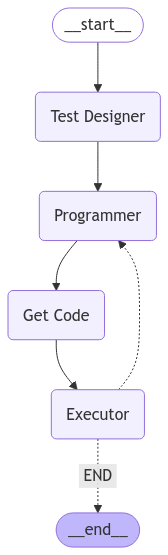

In [15]:
# View
display(Image(coder.get_graph(xray=1).draw_mermaid_png()))

## Run the Agent

Execute the graph in streaming mode and render the messages. We use the ‘values’ streaming mode, which retains the entire chat history at each step. To focus on updates, only the most recent message is displayed. As input we pick an example of the [HumanEval](https://github.com/openai/human-eval)[@chen2021codex] test set.

In [16]:
# One sample from the HumanEval testset
problem = {
    "task_id": "HumanEval 2",
    "prompt": '\n\ndef truncate_number(number: float) -> float:\n    """ Given a positive floating point number, it can be decomposed into\n    and integer part (largest integer smaller than given number) and decimals\n    (leftover part always smaller than 1).\n\n    Return the decimal part of the number.\n    >>> truncate_number(3.5)\n    0.5\n    """\n',
    "canonical_solution": "    return number % 1.0\n",
    "test": "\n\nMETADATA = {\n    'author': 'jt',\n    'dataset': 'test'\n}\n\n\ndef check(candidate):\n    assert candidate(3.5) == 0.5\n    assert abs(candidate(1.33) - 0.33) < 1e-6\n    assert abs(candidate(123.456) - 0.456) < 1e-6\n",
    "entry_point": "truncate_number",
}

# Input
initial_input = {
    "prompt": problem["prompt"],
    "entry_point": problem["entry_point"],
}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the agent by streaming the graph
for event in coder.stream(initial_input, thread, stream_mode="values"):
    if event["messages"]:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Let's break down the task of implementing the `truncate_number` function using the Chain-of-Thought approach.

1. **Understand and Clarify**: 
   - The function is supposed to take a positive floating-point number and return its decimal part. 
   - The decimal part is defined as the difference between the original number and its integer part.

2. **Algorithm/Method Selection**: 
   - To get the integer part of a floating-point number, we can use the `int()` function, which truncates the decimal part.
   - The decimal part can then be calculated by subtracting the integer part from the original number.

3. **Pseudocode Creation**: 
```
function truncate_number(number):
    if number is not positive:
        raise an error (or handle it as needed)
    integer_part = int(number)  # Get the integer part
    decimal_part = number - integer_part  # Calculate the decimal part
    return decimal_part  # Return th

Last, we access the final implementation and run it against the HumanEval test cases. 

In [17]:
# Access the final state of the graph
state = coder.get_state(thread)

# Run tests on the final implementation
exec(state.values["code"][-1] + problem["test"] +
     f"\ncheck({problem['entry_point']})")

print(f'Tests ran successful after {len(state.values["code"])} iterations!')

Tests ran successful after 4 iterations!
